# Programming Assignment 1
## Problem
Image filtering and frequency domain analysis
## Goals
1. Read and visualize an image
2. Design and apply filters using convolution
3. Derive the Discrete-time Fourier Series (DTFS) coefficients
4. Use the convolution property in the frequency domain 

# Read an Image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import imageio
from skimage.transform import resize

plt.rcParams['figure.figsize'] = (7, 7)

C:\Users\psw04\AppData\Local\Temp\ipykernel_22856\987063384.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('./image/00.png')/ 255


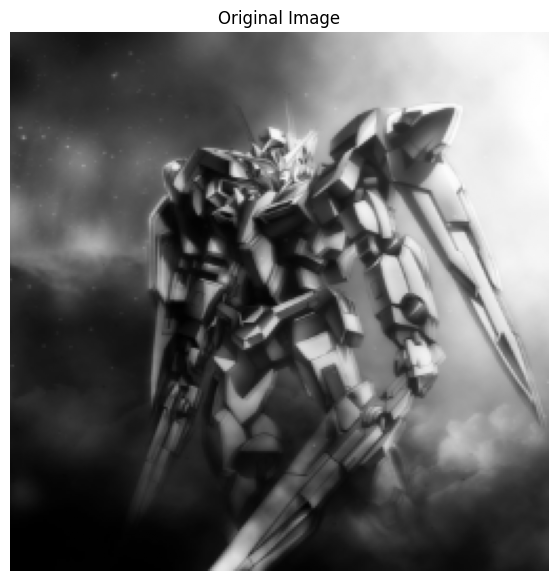

(256, 256)


In [3]:
image = imageio.imread('./image/00.png')/ 255
image = 0.2125 * image[:, :, 0] + 0.7154 * image[:, :, 1] + 0.0721 * image[:, :, 2]
image = resize(image, (256, 256), anti_aliasing=True)

plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

print(image.shape)


In [4]:
print(image[:5, :5])

[[0.16750055 0.16843876 0.16508343 0.16204312 0.16119996]
 [0.16871002 0.16919501 0.16733432 0.16465045 0.16108947]
 [0.16647176 0.16573529 0.16469192 0.164678   0.16014979]
 [0.16142742 0.16380241 0.16384789 0.16141642 0.15732873]
 [0.15856799 0.15865434 0.15701659 0.1540059  0.15342769]]


# Design a low-pass filter

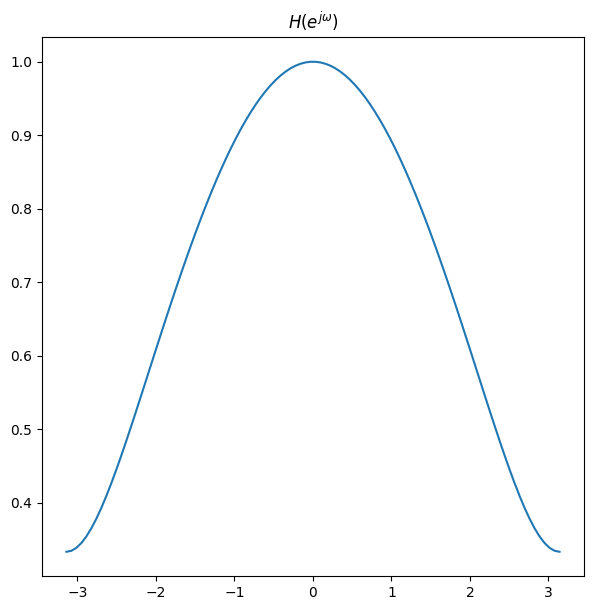

In [6]:
def DTFT(signal, w):
    N = len(signal)
    dtft = np.zeros(N, dtype=complex)

    for n in range(N):
        dtft[n] = signal[n] * np.exp(-1j * w * n)

    return np.sum(dtft)

def make_kernel(size, param):
    kernel = [1,2]
    # TODO

    return kernel / np.sum(kernel)

kernel = make_kernel(size = 15, param = 1)

# Draw DTFT of the kernel
omega = np.linspace(-np.pi, np.pi, 100)
dtft_kernel = np.zeros_like(omega)
for i, w in enumerate(omega):
    dtft_kernel[i] = np.abs(DTFT(kernel, w))

plt.plot(omega, dtft_kernel)
plt.title(r'$H(e^{j\omega})$')
plt.show()

# Apply convolution

In [ ]:
def conv2d(image, kernel):
    H, W = image.shape
    temp = np.zeros_like(image)
    for i in range(H):
        temp[i, :] = np.convolve(image[i, :], kernel, mode='same')

    result = np.zeros_like(image)
    for j in range(W):
        result[:, j] = np.convolve(temp[:, j], kernel, mode='same')
    return result

lpf_conv_result = conv2d(image, kernel)

# Design corresponding high-pass filter & apply convolution

In [8]:
# Corresponding High pass filter 1
# TODO

hpf_result = conv2d(image, kernel2)
hpf_result = (hpf_result - hpf_result.min()) / ( hpf_result.max() - hpf_result.min())

plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.imshow(lpf_conv_result, cmap='gray')
plt.title('Low-pass Filtered using Convolution')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(hpf_result, cmap='gray')
plt.title('High-pass Filtered')
plt.axis('off')
plt.show()

NameError: name 'conv2d' is not defined

# Discrete-time Fourier Series

In [ ]:
def dtfs_matrix(N):
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = 1/N * np.exp(-2j * np.pi * k * n / N)
    return W

In [ ]:
def analysis_1d(x):
    N = len(x)
    W = dtfs_matrix(N)
    return W @ x

def synthesis_1d(a):
    N = len(a)
    W = N * np.conj(dtfs_matrix(N).T)
    return W @ a

In [ ]:
def analysis_2d(img):
    M, N = img.shape
    W_M = dtfs_matrix(M)
    W_N = dtfs_matrix(N)
    return W_M @ img @ W_N.T

def synthesis_2d(F):
    M, N = F.shape
    W_M = M * np.conj(dtfs_matrix(M).T)
    W_N = N * np.conj(dtfs_matrix(N).T)
    return W_M @ F @ W_N.T

In [ ]:
H, W = image.shape

# Make zero phase
padded_kernel = np.zeros([H, 1])
ks = kernel.shape[0]
padded_kernel[:ks, 0] = kernel
padded_kernel = np.roll(padded_kernel, -ks // 2 + 1, axis=0)
padded_kernel2d = padded_kernel @ padded_kernel.T

# DTFS Coefficients
F_image = analysis_2d(image)
F_kernel = analysis_2d(padded_kernel2d)

# Pointwise multiplication
F_filtered = H * W * F_image * F_kernel

# Synthesize the image
lpf_fourier = np.real(synthesis_2d(F_filtered))

plt.imshow(lpf_fourier, cmap='gray')
plt.title('Low-pass Filtered Image (Fourier Multiplication)')
plt.axis('off')
plt.show()

In [ ]:
def to8(im):
    return np.round(np.clip(im*255, 0, 255)).astype(np.uint8)

imageio.imwrite('./image/LPF_convolution.png', to8(lpf_conv_result))
imageio.imwrite('./image/LPF_fourier.png', to8(lpf_fourier))